generate final prediction


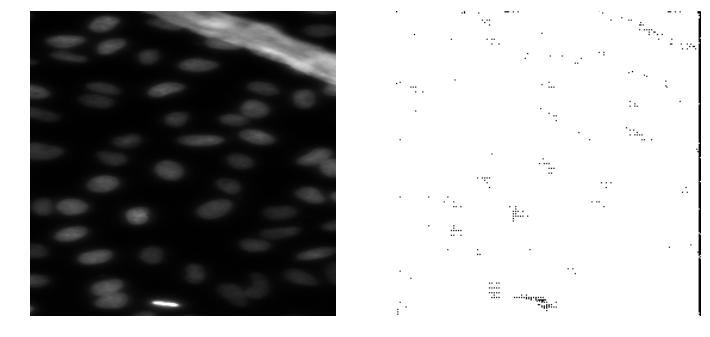

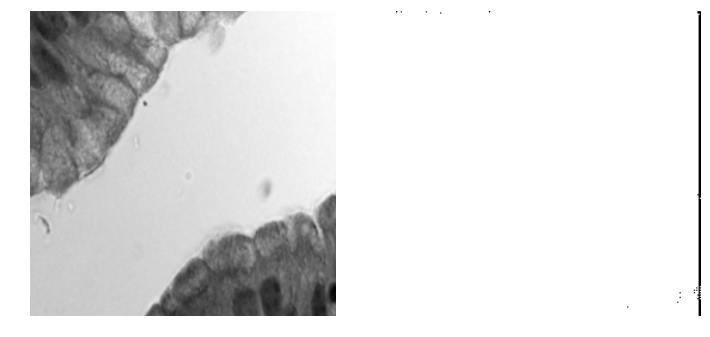

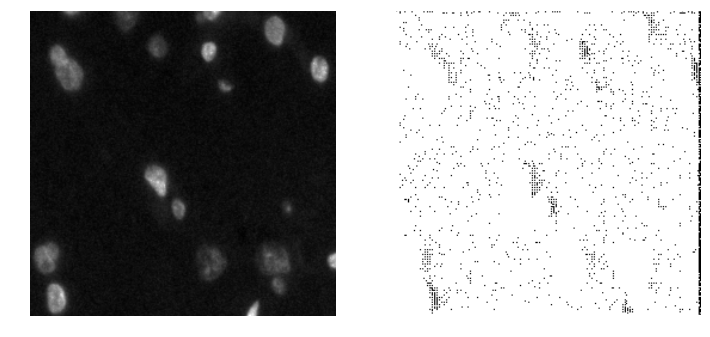

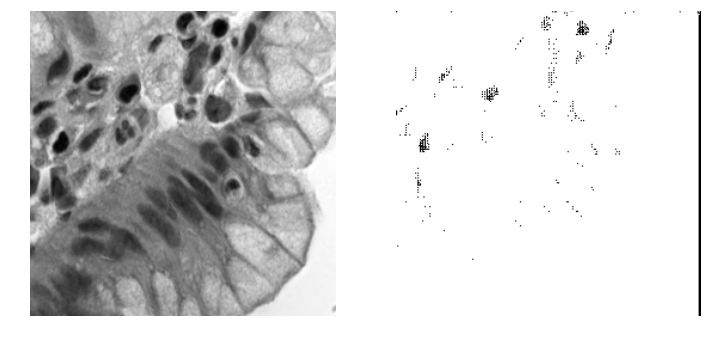

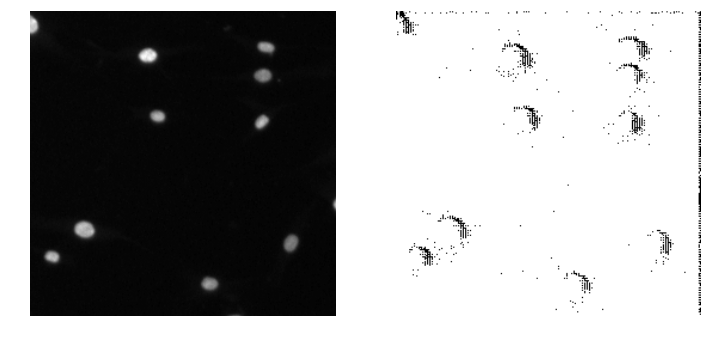

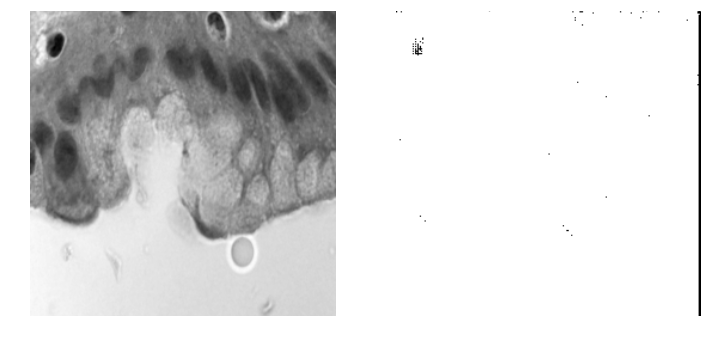

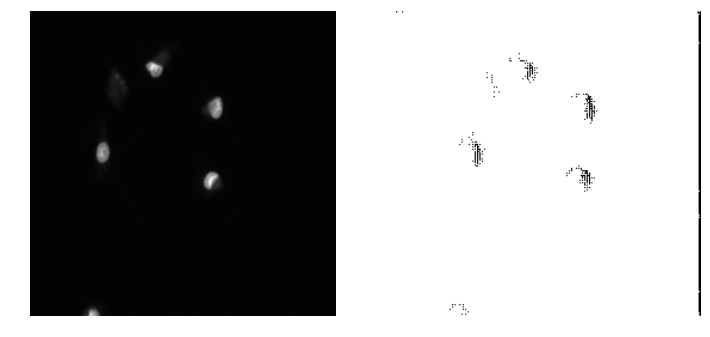

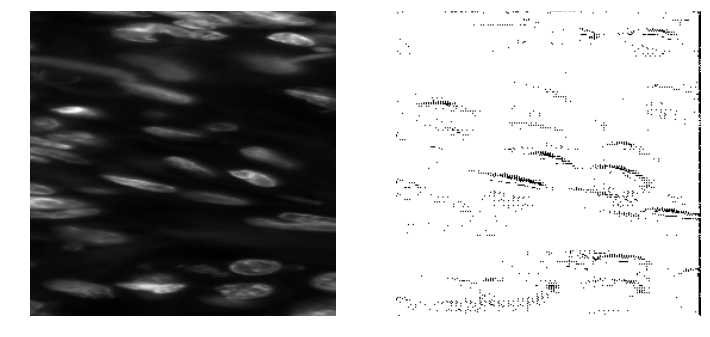

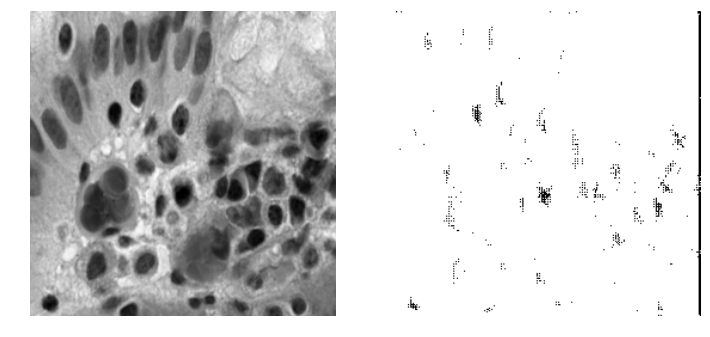

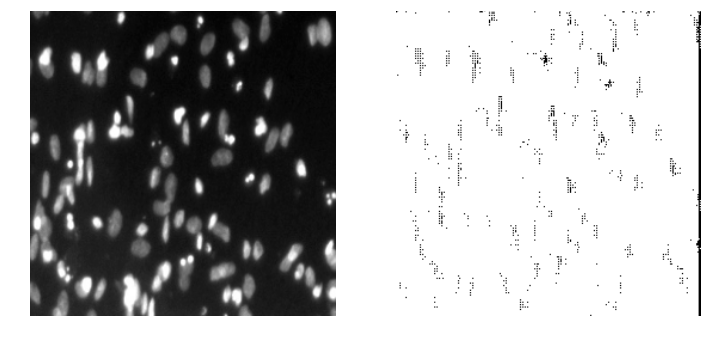

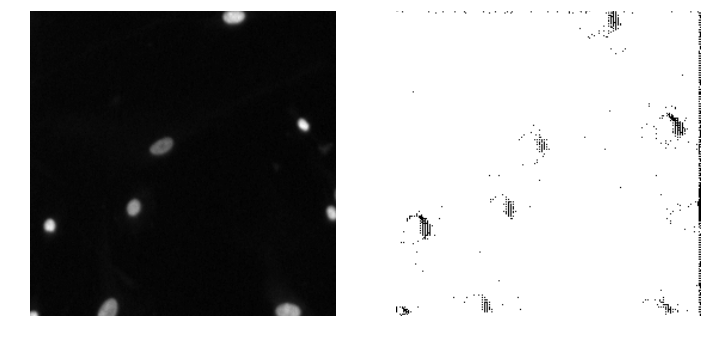

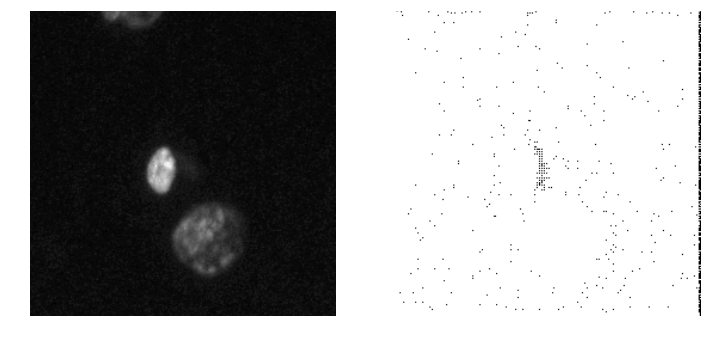

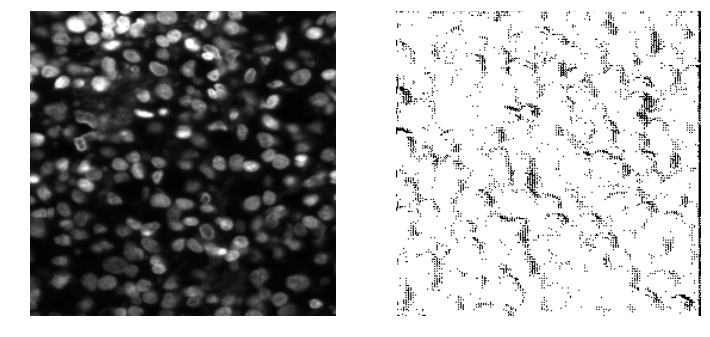

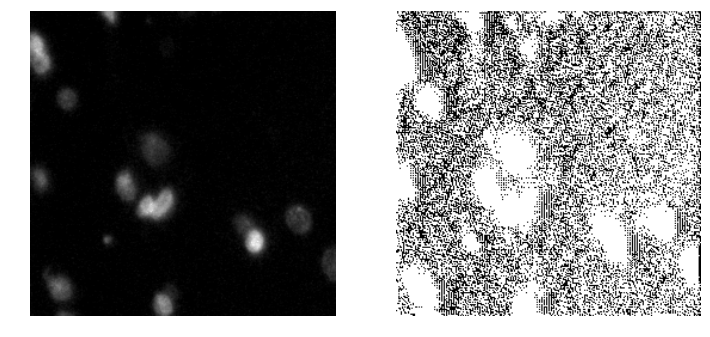

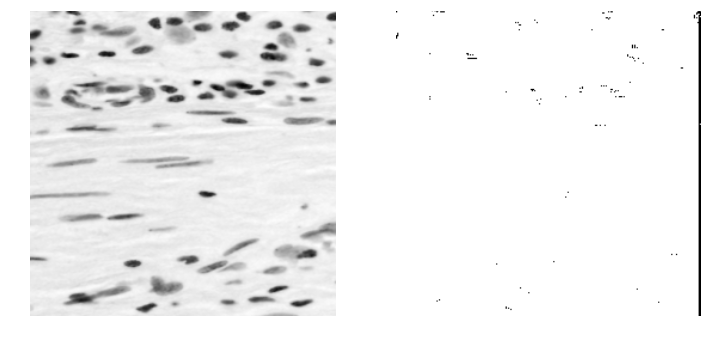

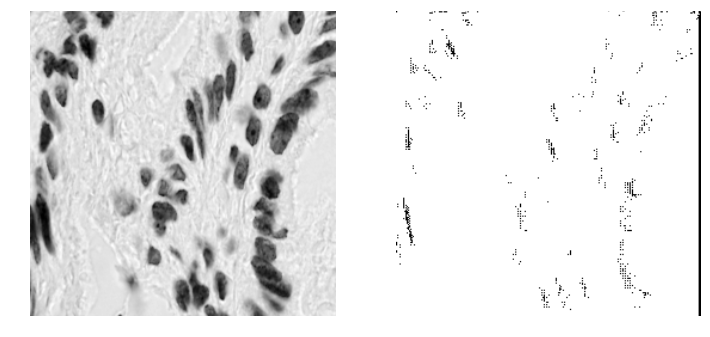

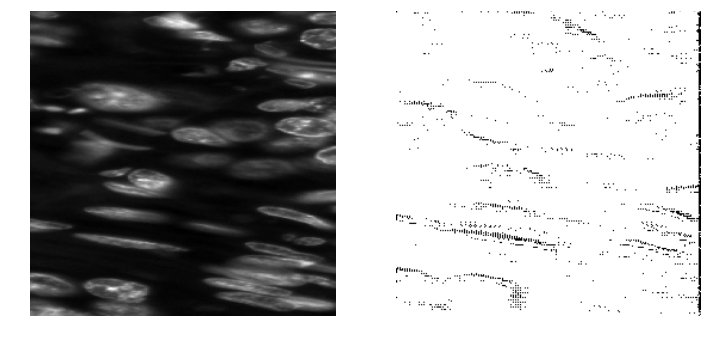

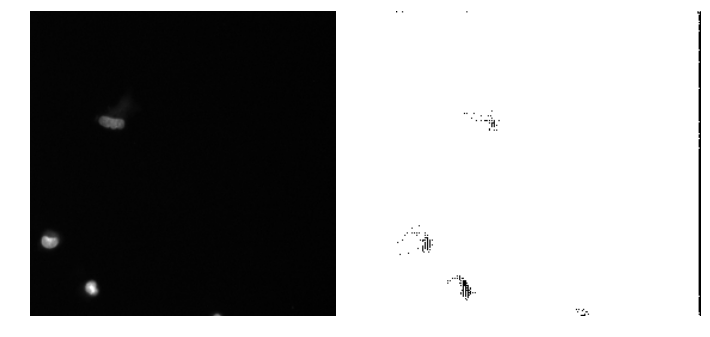

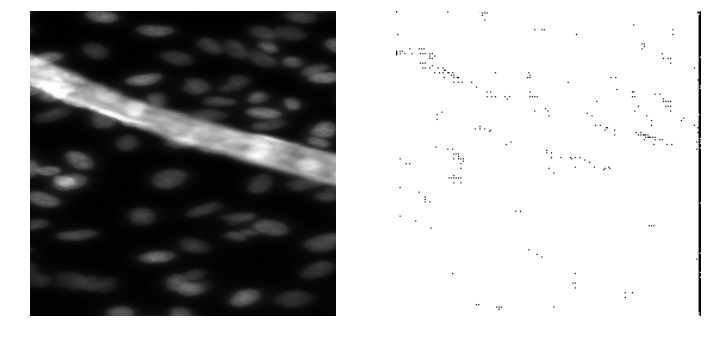

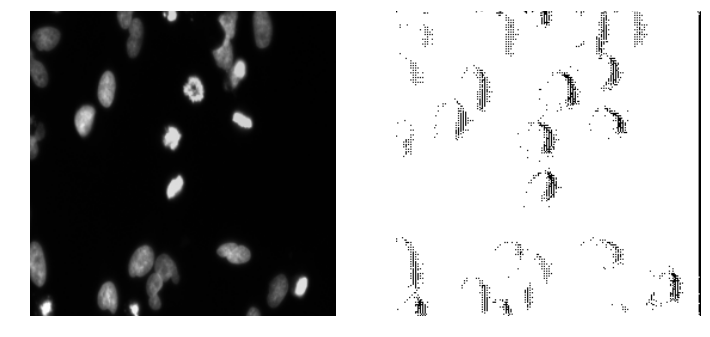

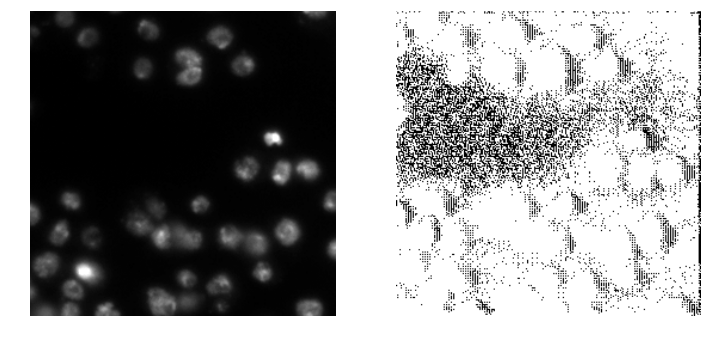

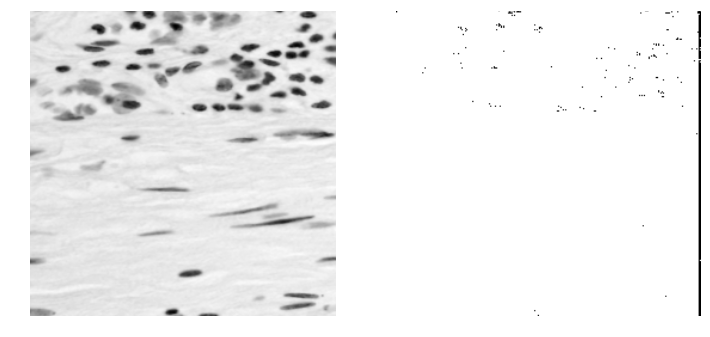

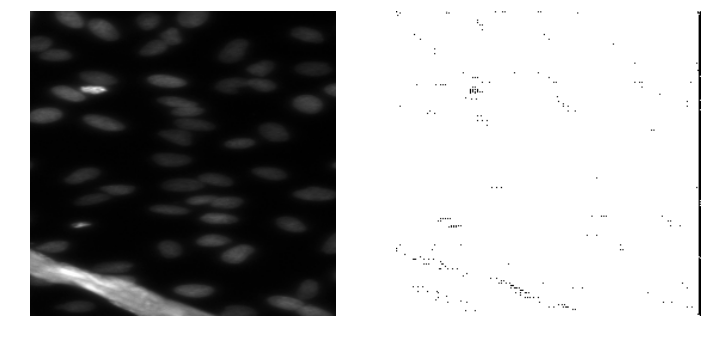

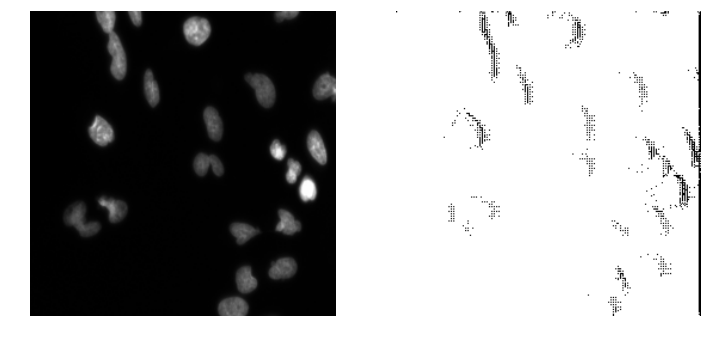

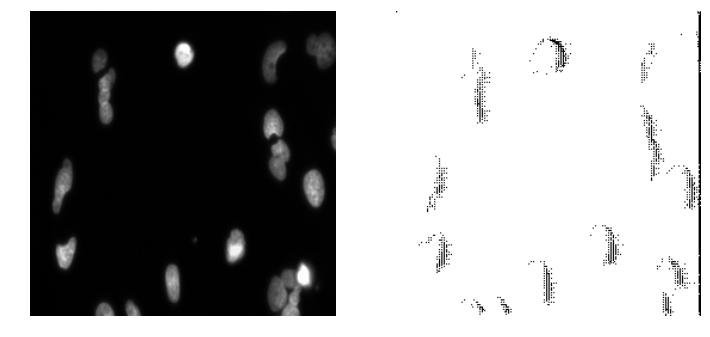

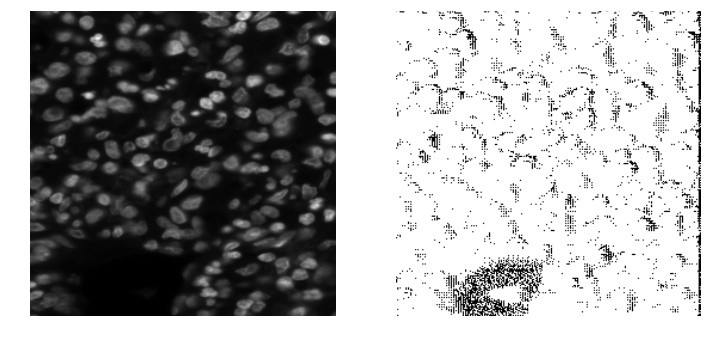

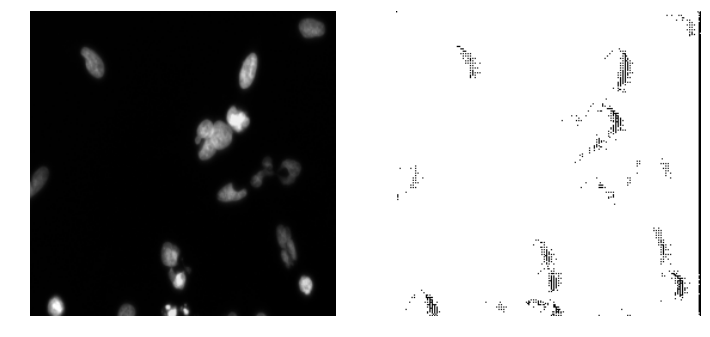

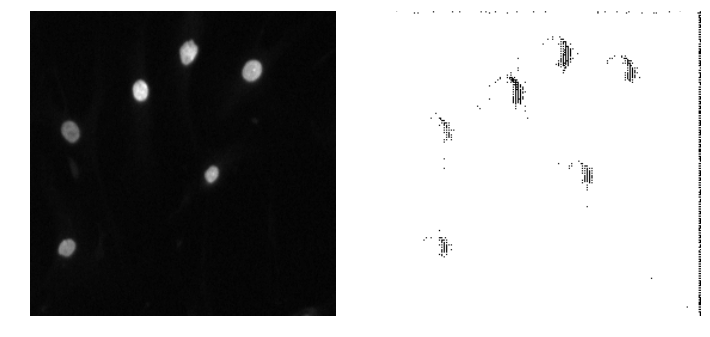

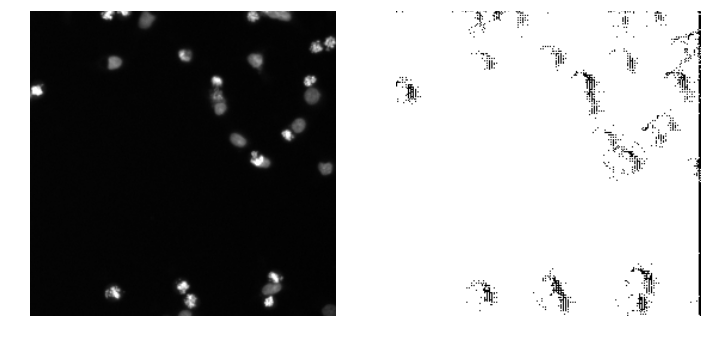

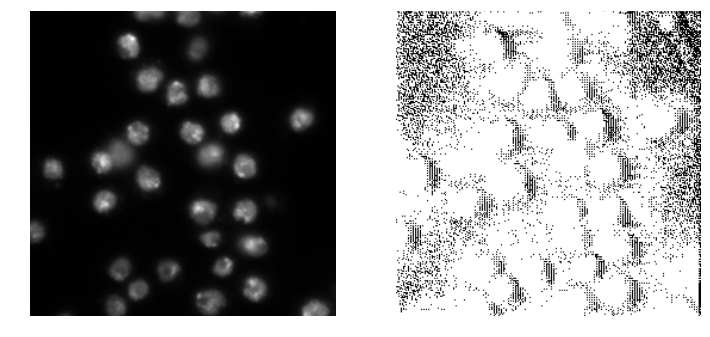

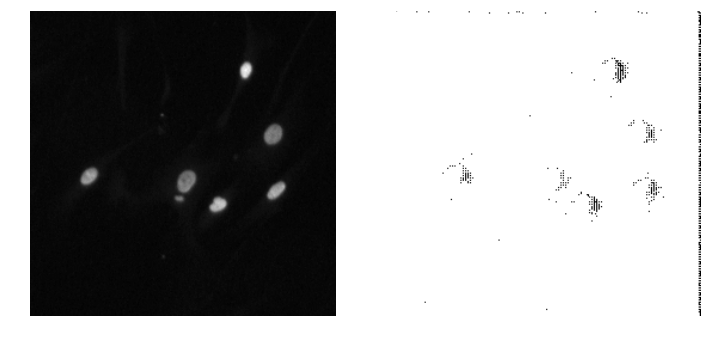

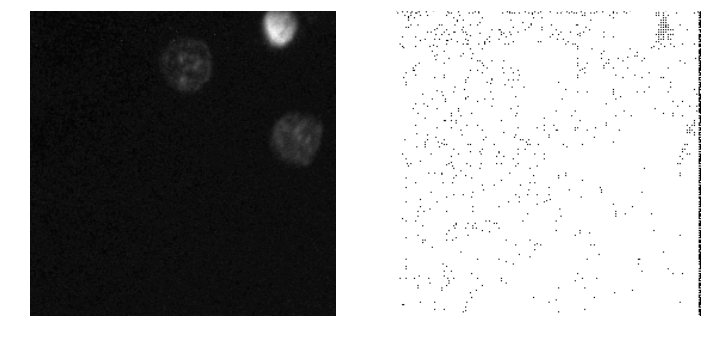

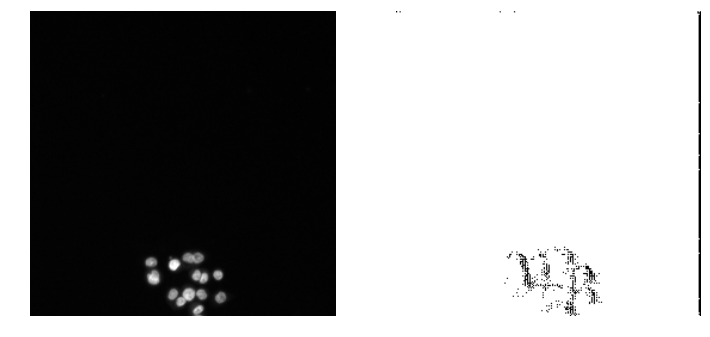

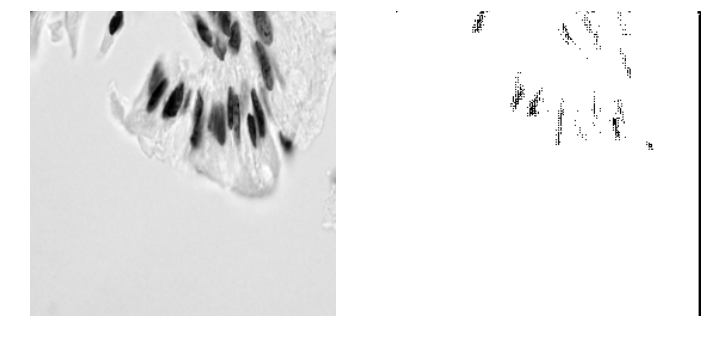

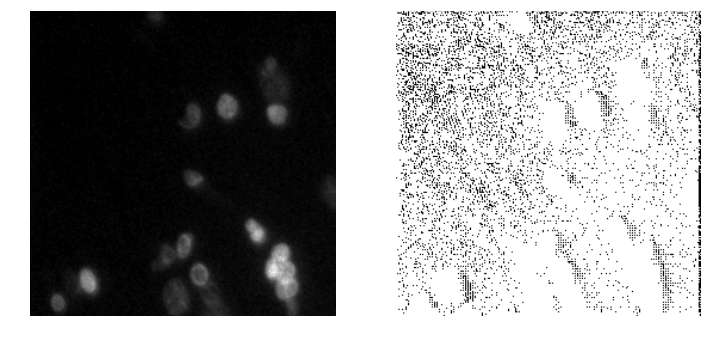

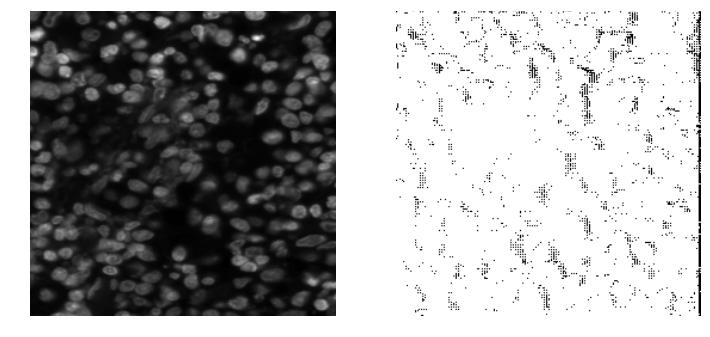

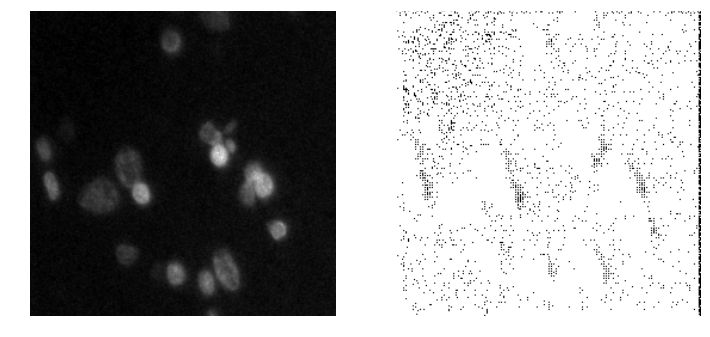

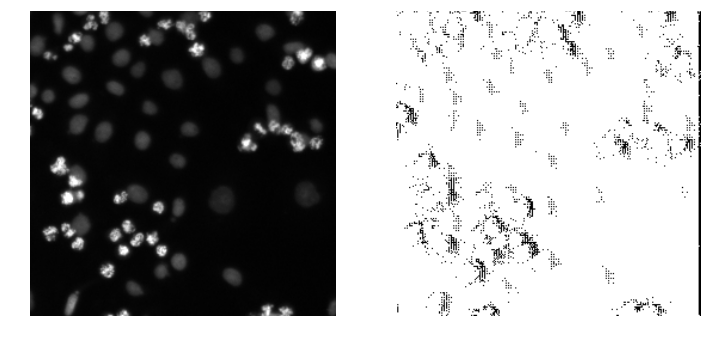

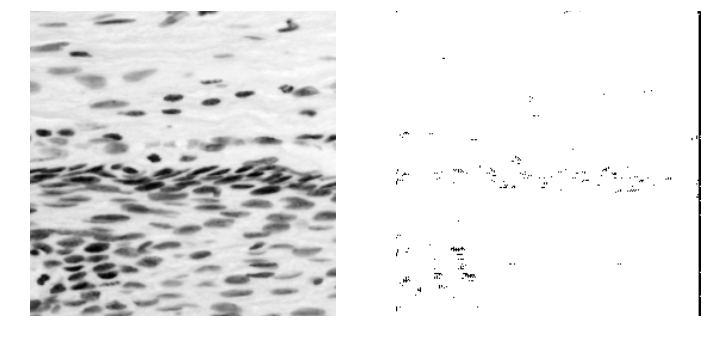

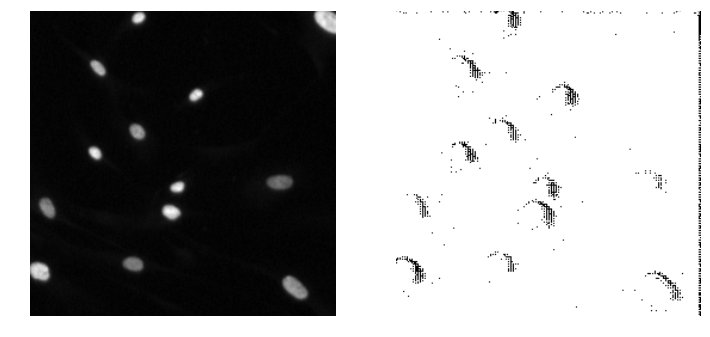

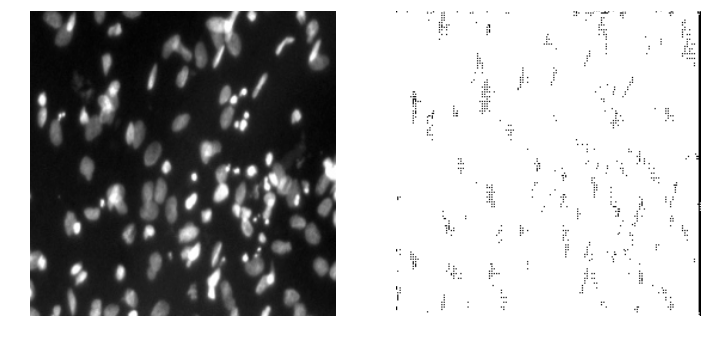

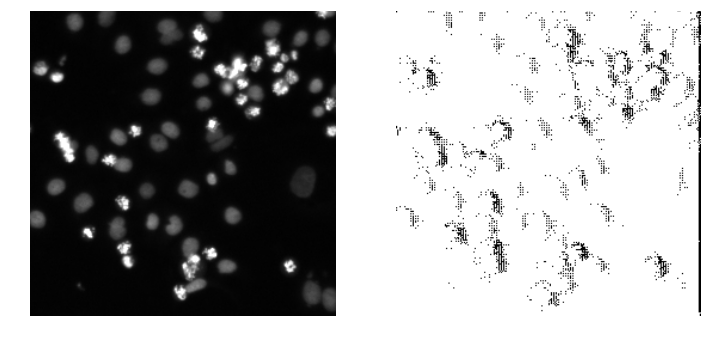

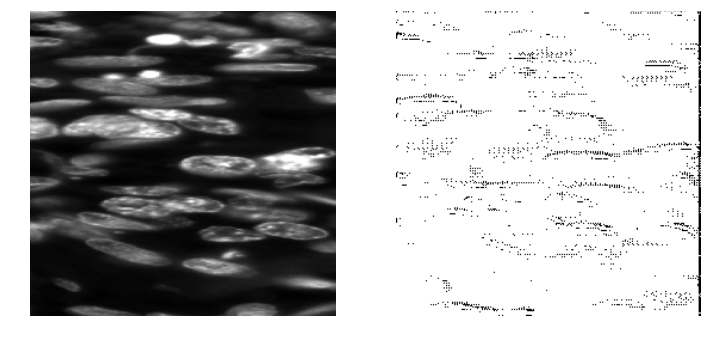

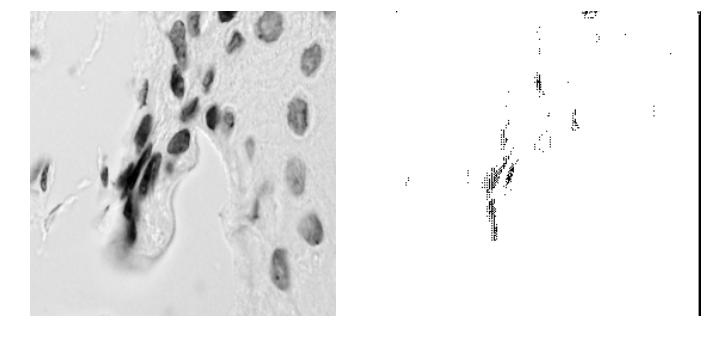

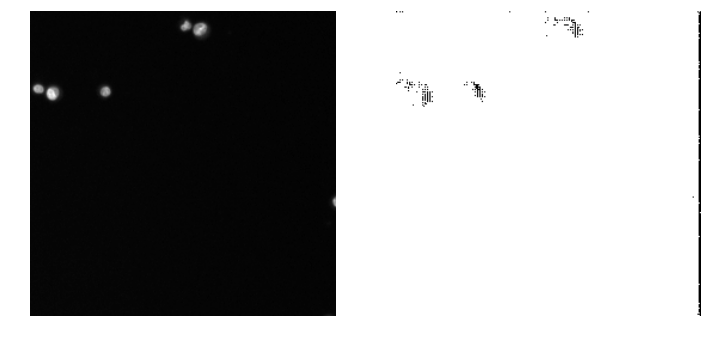

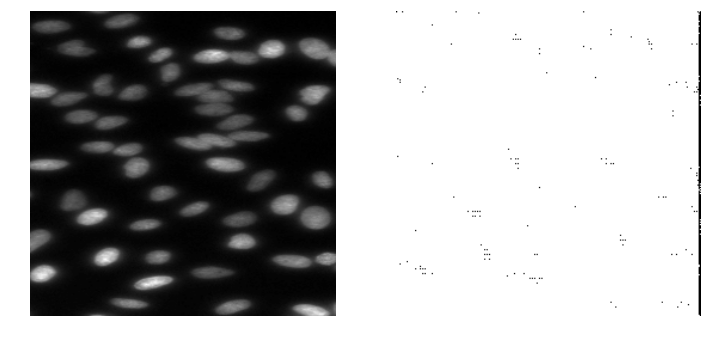

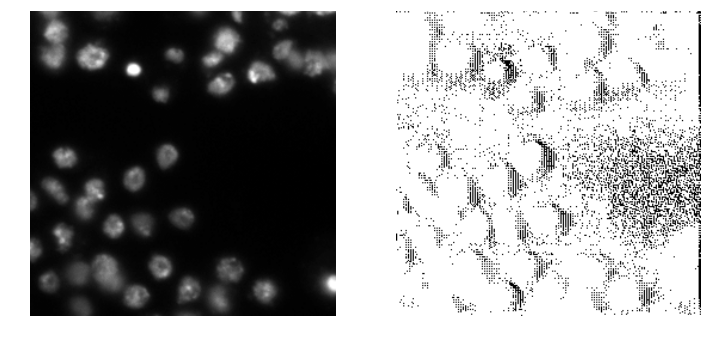

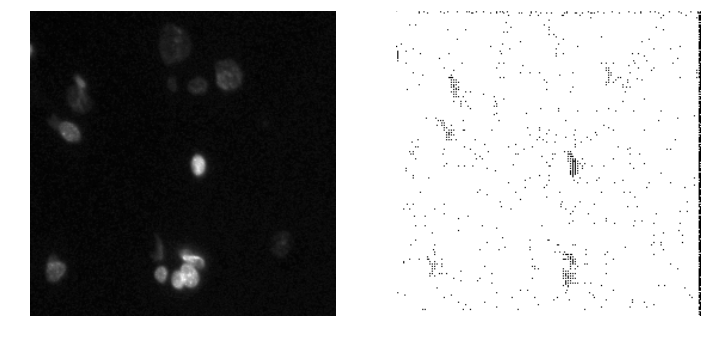

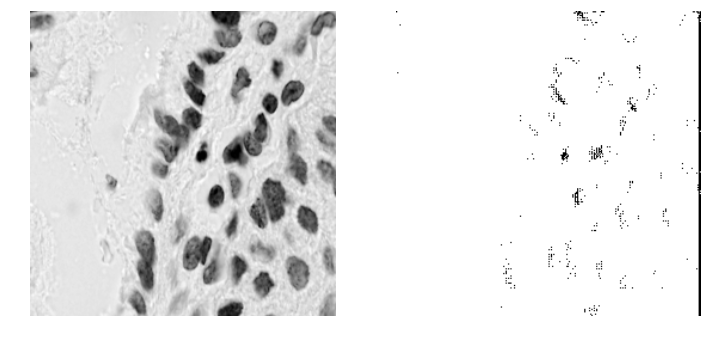

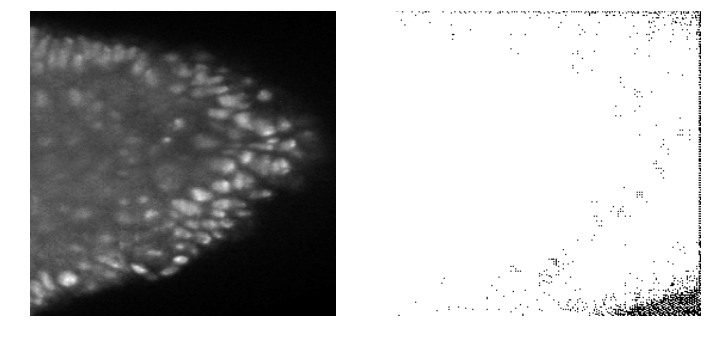

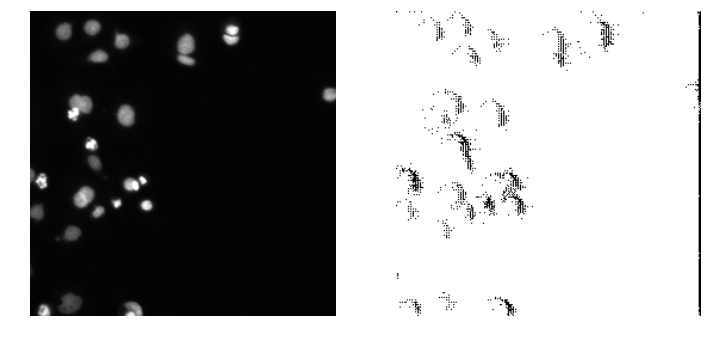

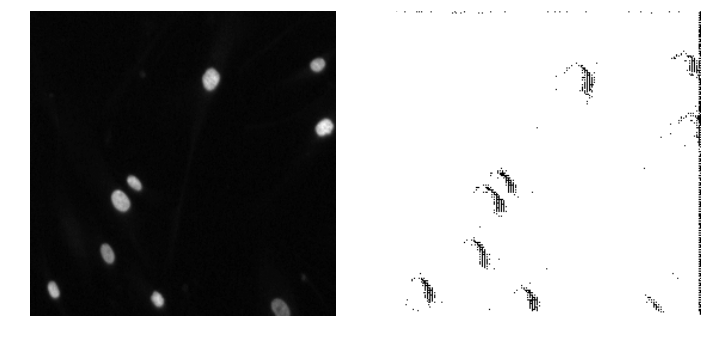

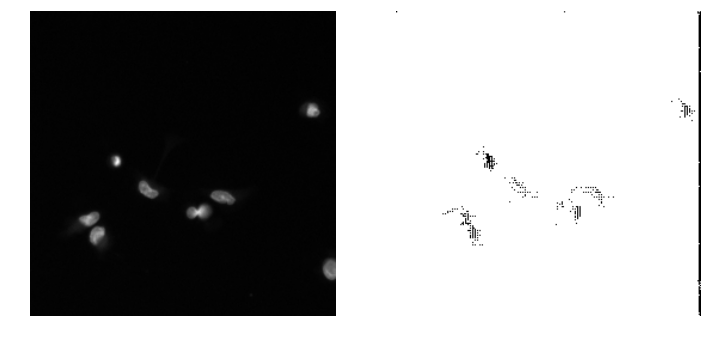

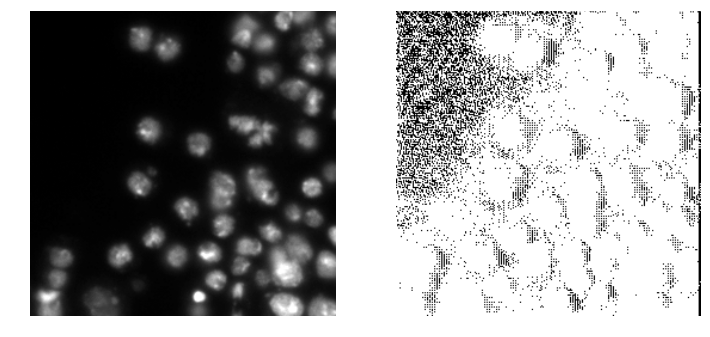

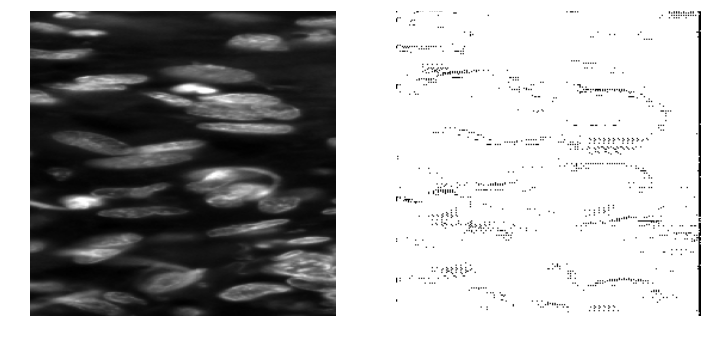

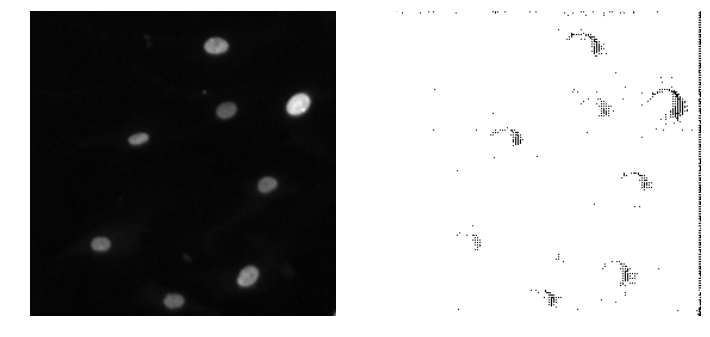

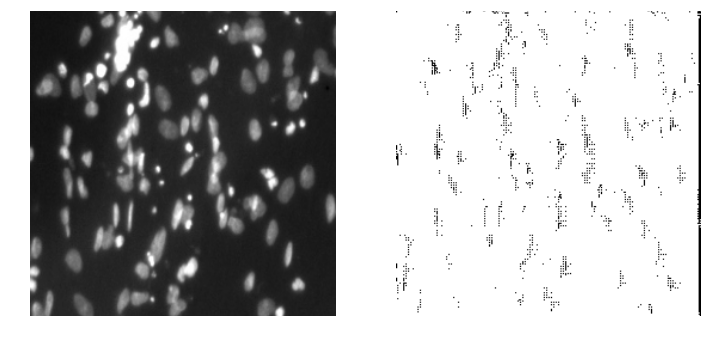

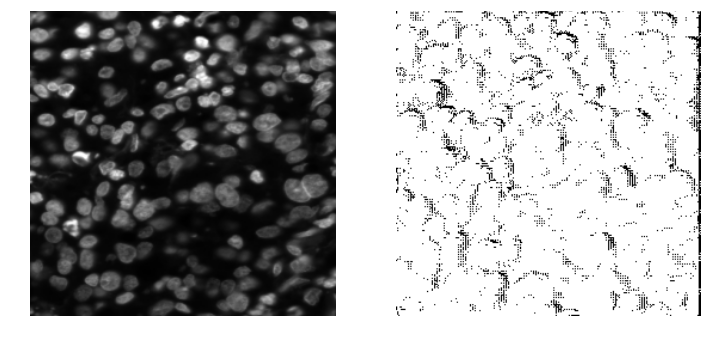

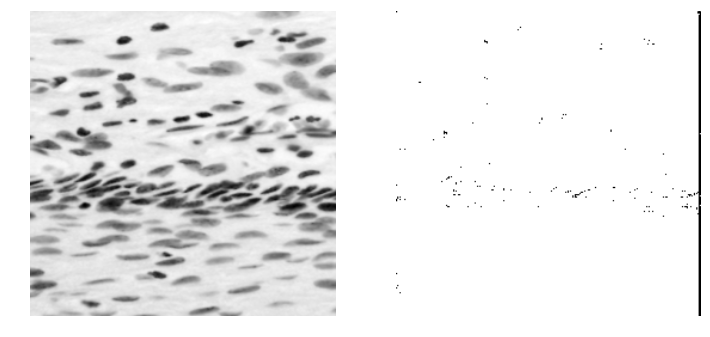

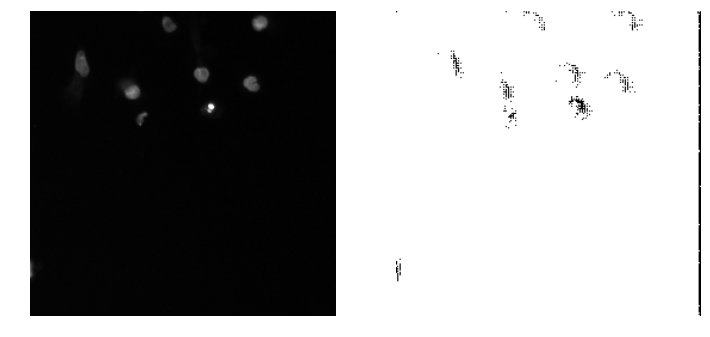

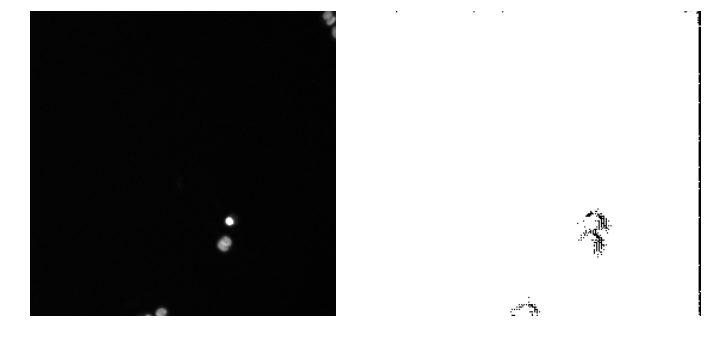

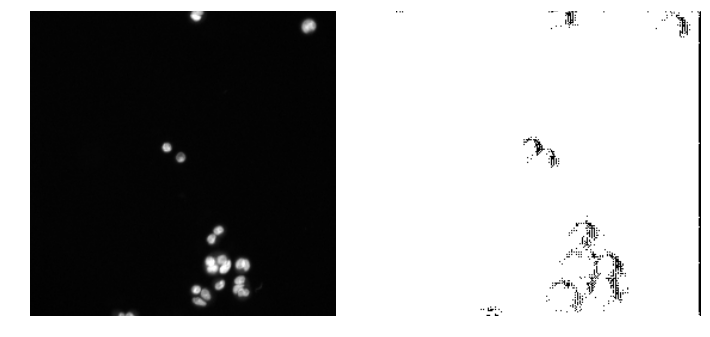

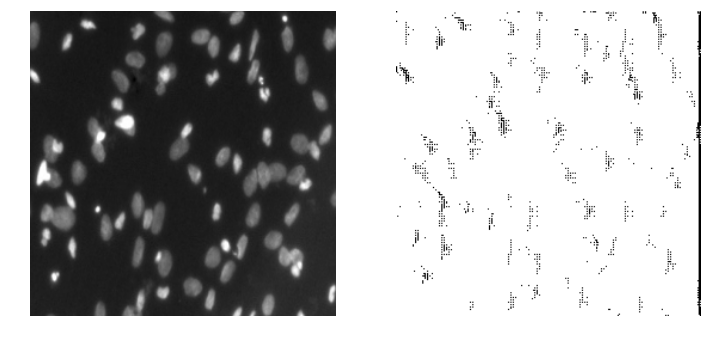

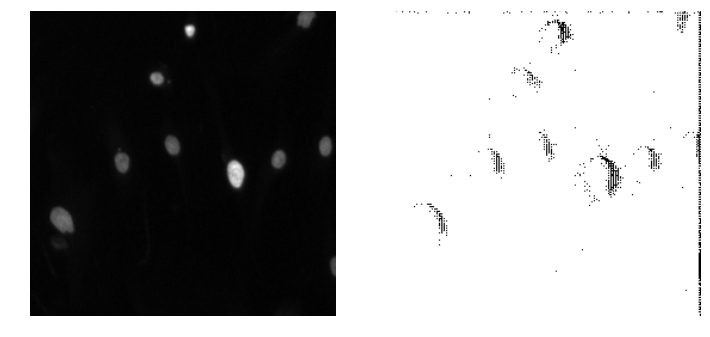

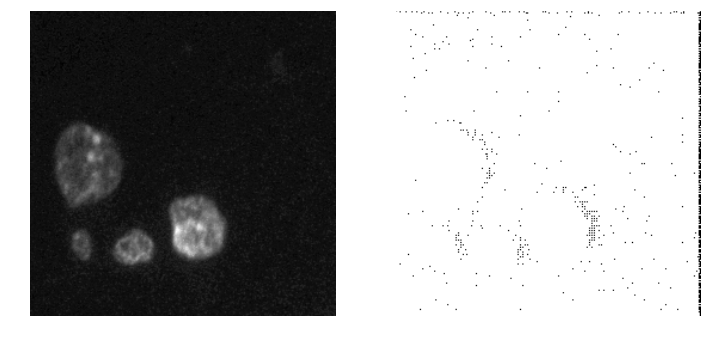

In [20]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import random

import cv2
from skimage import io
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from tqdm import tqdm
import skimage.morphology as morph
from scipy import ndimage as ndi
from scipy.stats import itemfreq
from sklearn.externals import joblib
import pylab
from util import plots

data_path = 'data/prediction_data.npz'
data_dst_path = 'data/prediction_data_final.npz'
batch_size = 1

def load_data():
    data = np.load(data_path)
    imgs = data['images']
    masks = data['masks']
    contours = data['contours']
    return imgs, masks, contours

def morphological_method(image, mask, contour):
    mask = np.squeeze(mask, axis=2)
    contour = np.squeeze(contour, axis=2)
  
    # mask -> binary mask, otsu
    mask_binary, contour_binary = binary_mask(mask, contour)
    contour_binary_thin = morph.binary_erosion(contour_binary)
    
    # cut the mask by contour
    mask_tmp = np.where(~mask_binary | contour_binary_thin, 0, 1)
    mask_tmp = np.expand_dims(mask_tmp, axis=2)
    plots([image, mask_binary, contour, mask_tmp])

    return mask_tmp

def binary_mask(mask, contour):
    # mask -> binary mask, otsu
#     m_thresh = threshold_otsu(mask)
#     c_thresh = threshold_otsu(contour)
    m_thresh = 0.5
    c_thresh = 0.5
    mask_binary = mask > m_thresh
    contour_binary = contour > c_thresh
    return mask_binary, contour_binary


def post_processing(images, masks, contours, mode=1):
    # mode=1 with contour, mode=0 no contour
    num_img = masks.shape[0]
    masks_final = np.zeros(masks.shape)
    if mode == 0:
        for i in range(num_img):
            mask_binary, contour_binary = binary_mask(masks[i,:,:,:], contours[i,:,:,:])
            masks_final[i,:,:] = mask_binary
            plots([images[i,:,:,:], mask_binary])
    else:
        for i in range(num_img):
            masks_final[i,:,:] = morphological_method(images[i,:,:,:], masks[i,:,:,:], contours[i,:,:,:])
#             plots([images[i,:,:,:], masks_final[i,:,:]])
    np.savez_compressed(data_dst_path, images=images, masks=masks, contours=contours, result=masks_final)

imgs, masks, contours = load_data()
post_processing(imgs, masks, contours, mode=0)
print("generate final prediction")